# Simple regression with bayesian neural networks

In this notebook you will find a comparison between two bayesian methods to assess uncertainty when dealing with neural networks: **Monte-Carlo Dropout** (["Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)) and **Bayesian by Backpropagation** (["Weight Uncertainty in Neural Networks"](https://arxiv.org/abs/1505.05424)). We study a very simple toy regression model in 1D.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

import torch
from torch.utils import data

## 0. Data preparation

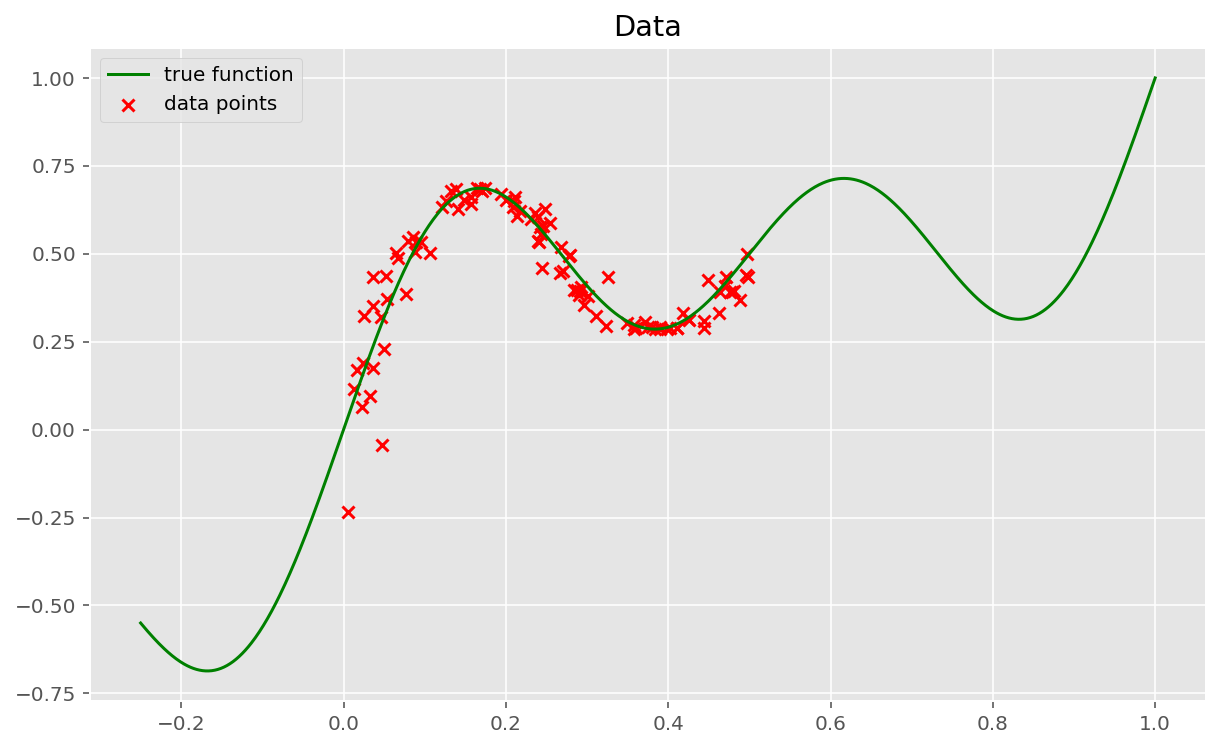

In [2]:
N = 100  #number of training data points
sigma = 0.02
dataset = {}

def function(x, epsilon):
    return x + 0.3 * np.sin(2 * np.pi * (x + epsilon)) + 0.3 * np.sin(4 * np.pi * (x + epsilon)) + epsilon

dataset['X_train'] = np.random.uniform(0, 0.5, N)
dataset['y_train'] = function(dataset['X_train'], np.random.normal(0, sigma, N))

dataset['X_test'] = np.linspace(-0.25, 1, 1000)
F = function(dataset['X_test'], 0)

plt.figure(figsize=(10, 6))
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.scatter(dataset['X_train'], dataset['y_train'], marker='x', color='red', label='data points')
plt.legend()
plt.title("Data")
plt.show()

In [3]:
X_train_tensor = torch.from_numpy(dataset['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset['X_test'].copy()).float().unsqueeze(dim=1)

## 1. Deterministic regression

In [105]:
import models.deterministic_regression as dreg

##### Definition of the model

In [106]:
net = dreg.DeterministicNet(hidden_size=100, dim_input=1, dim_output=1)
reg_model = dreg.DeterministicReg(X_train_tensor, y_train_tensor, X_test_tensor, net)

##### Training step

In [107]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion, batch=False)

##### Test step

In [108]:
y_pred = reg_model.predict()

##### Plot results

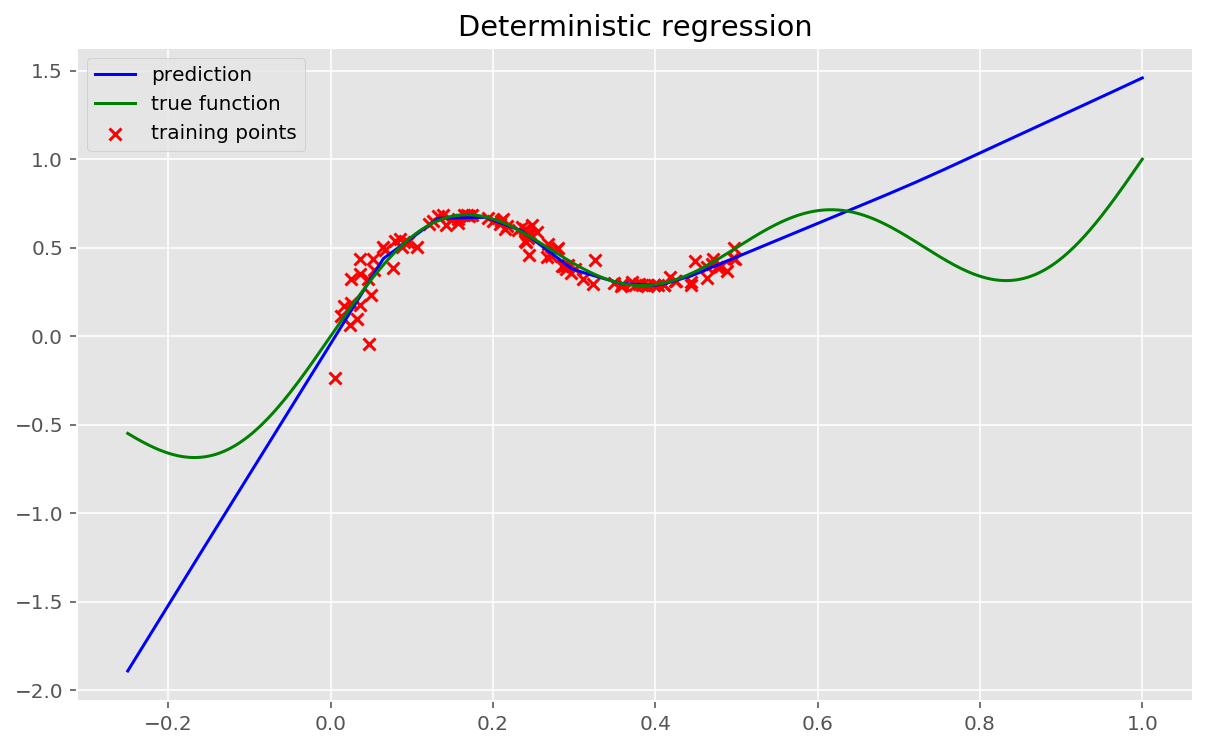

In [109]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title('Deterministic regression')
plt.show()

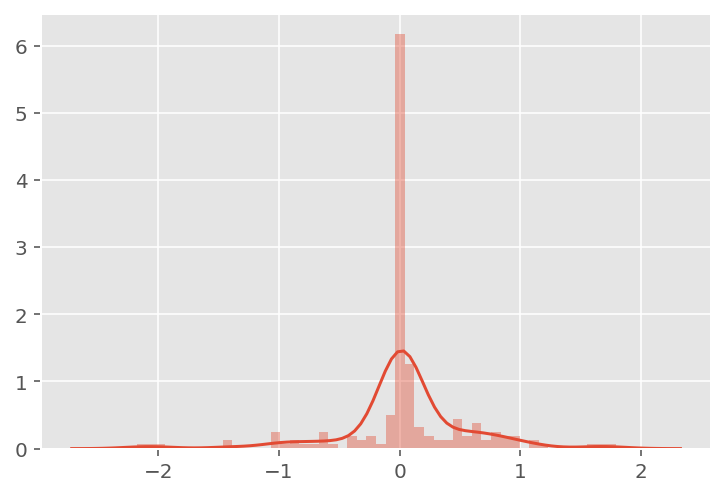

In [110]:
sns.distplot(net.weights_dist())

## 2. Bayesian regression with Monte-Carlo dropout

In [111]:
import models.dropout_regression as doreg

##### Definition of the model

In [112]:
net = doreg.DropoutNet(hidden_size=100, dim_input=1, dim_output=1, p=0.25)
reg_model = doreg.DropoutReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=X_train_tensor.shape[0])

##### Training step

In [113]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion)

##### Test step

In [114]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

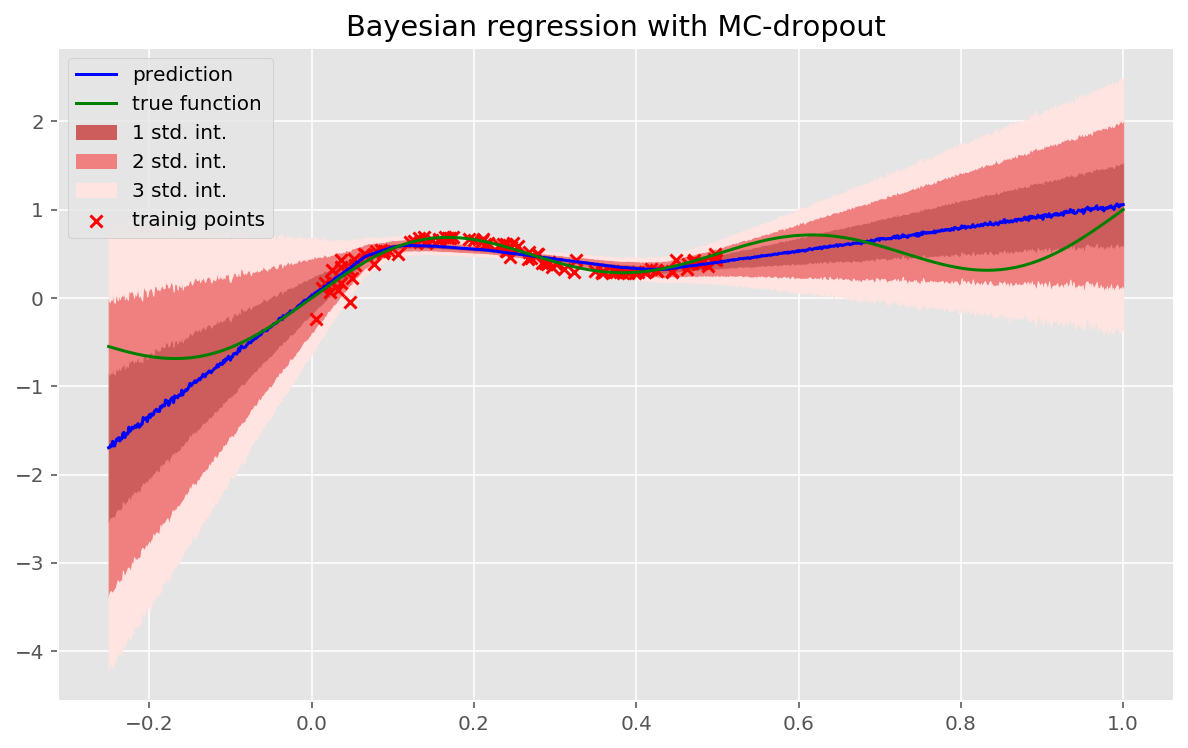

In [115]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title("Bayesian regression with MC-dropout")
plt.show()

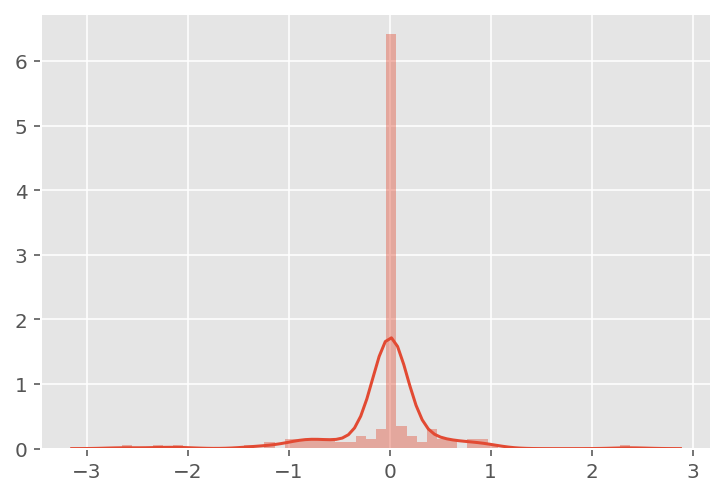

In [116]:
sns.distplot(net.weights_dist())

## 3. Bayesian regression with Bayesian by Backpropagation

In [94]:
import models.bayesbackprop_regression as bbb

##### Definition of the model

In [128]:
prior_parameters = {'sigma1': 1, 'sigma2': np.exp(-6), 'pi': 0.5}
net = bbb.BayesBackpropNet(hidden_size=100, dim_input=1, dim_output=1, prior_parameters=prior_parameters, sigma=0.001)
reg_model = bbb.BayesBackpropReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=10)

##### Training step

In [129]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, 2)

   0: 711753664.000000
  50: 2189574912.000000
 100: 3032522240.000000
 150: 22152404992.000000
 200: 846740992.000000
 250: 5176314880.000000
 300: 370513952.000000
 350: 746754304.000000
 400: 395450816.000000
 450: 1923870080.000000
 500: 536782528.000000
 550: 613160768.000000
 600: 932228608.000000
 650: 310700864.000000
 700: 312898656.000000
 750: 338194880.000000
 800: 36518384.000000
 850: 174739600.000000
 900: 164727504.000000
 950: 25082044.000000
1000: 76902336.000000
1050: 282935136.000000
1100: 162441952.000000
1150: 88422960.000000
1200: 30223828.000000
1250: 21041790.000000
1300: 17520028.000000
1350: 33665552.000000
1400: 32243308.000000
1450: 25209416.000000
1500: 16889048.000000
1550: 5000980.000000
1600: 72191560.000000
1650: 10667494.000000
1700: 3279504.500000
1750: 4814776.000000
1800: 2692260.500000
1850: 3036491.000000
1900: 3387685.000000
1950: 2320795.000000
2000: 3071003.000000
2050: 1768594.250000
2100: 2695370.000000
2150: 2105813.000000
2200: 1494595.625

##### Test step

In [126]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

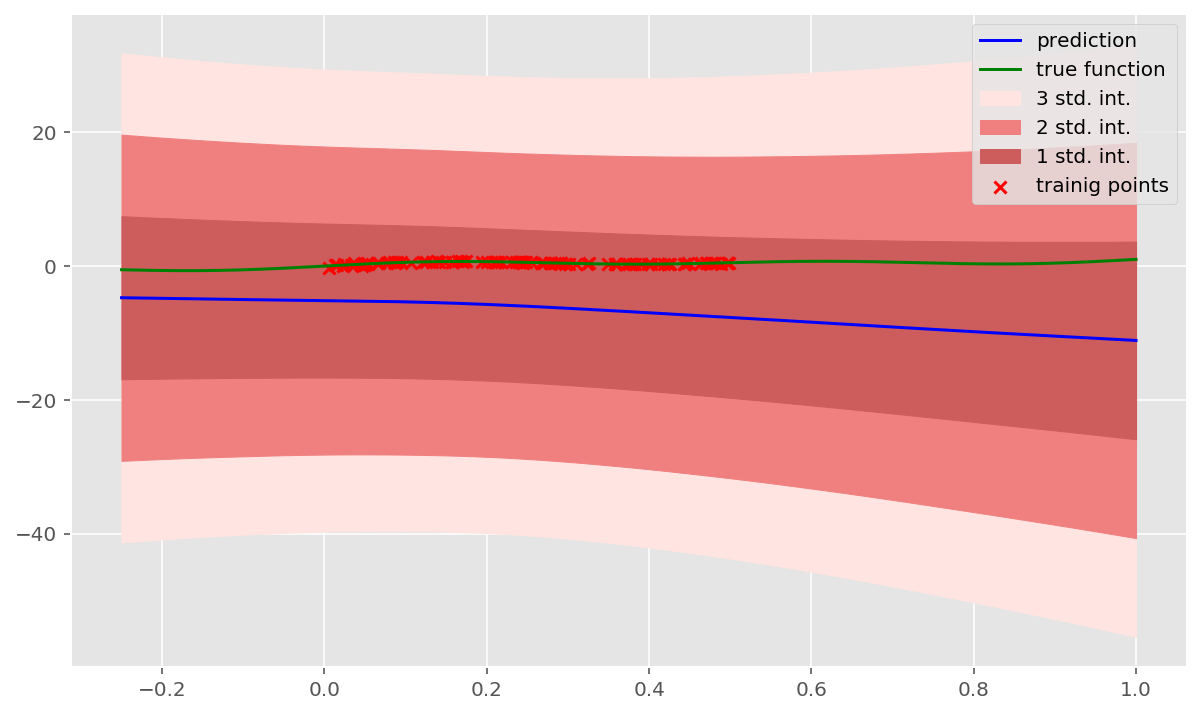

In [127]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.show()

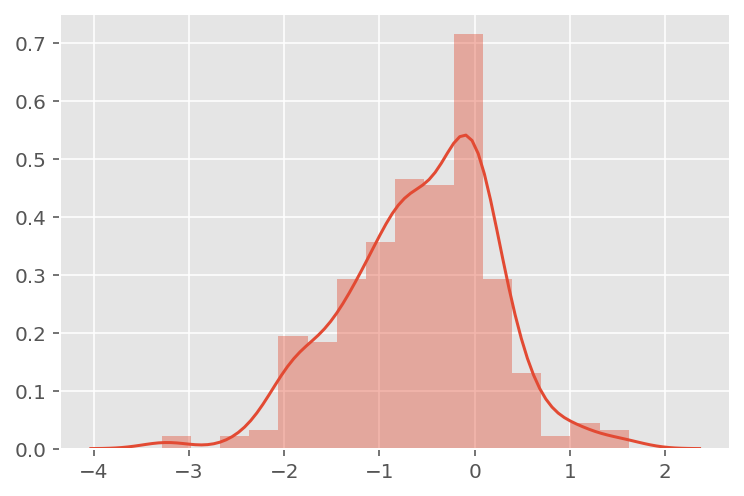

In [121]:
sns.distplot(net.weights_dist())